# Milestone 03
# Aeden Jameson

## Best Practices for Assignments & Milestones

- <b>Break the assignment into sections - one section per numbered requirement.</b> Each assignment has numbered requirements/instructions e.g. "1. Read the CIFAR-10 dataset". Each requirement should have at least one markdown cell and at least one code cell. Feel free to combine sections or make other sensible changes if that makes sense for your code and is still clear. The intent is to give you a useful structure and to make sure you get full credit for your work.

- <b>Break the milestone into sections - one section for each item in the rubric.</b> Each milestone has rubric items e.g. "5. Handle class imbalance problem". Each rubric item should have at least one markdown cell and at least one code cell. Feel free to combine sections or make other sensible changes if that makes sense for your code and is still clear. The intent is to give you a useful structure and to make sure you get full credit for your work.

- <b>Include comments, with block comments preferred over in-line comments.</b> A good habit is to start each code cell with comments.

The above put into a useful pattern:

<b>Markdown cell:</b> Requirement #1: Read the CIFAR-10 dataset<br>
<b>Code cell:</b>: Comments followed by code<br>
<b>Markdown cell:</b> Requirement #2: Explore the data<br>
<b>Code cell:</b>: Comments followed by code<br>
<b>Markdown cell:</b> Requirement #3: Preprocess the data and prepare for classification<br>
<b>Code cell:</b>: Comments followed by code<br>

For more information:
- A good notebook example: [DataFrame Basics](https://github.com/Tanu-N-Prabhu/Python/blob/master/Pandas/Pandas_DataFrame.ipynb) 
- More example notebooks: [A gallery of interesting Jupyter Notebooks](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks#pandas-for-data-analysis)
- [PEP 8 on commenting](https://www.python.org/dev/peps/pep-0008/)
- [PEP 257 - docstrings](https://www.python.org/dev/peps/pep-0257/)

Occasionally an assignment or milestone will ask you to do something other than write Python code e.g. ask you turn in a .docx file. In which case, please use logical structuring, but the specific notes above may not apply.

# Milestone 03 

## Problem

Identify the most important features in the diaper manufacturing process that result in the production of the desired quality of diaper.

## Step 0: Read & Prepare

In [1]:
!pip install tensorflow

In [2]:
!pip install imblearn

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier

In [4]:
import requests
import re

def prepare(dataFilename = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data", labelsFilename="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"):
    names = ["f" + str(x) for x in range(1, 591)]
    
    data = pd.read_csv(dataFilename, names=names, delimiter=' ', header=None)    
    labels = pd.read_csv(labelsFilename, delimiter=' ', header=None, names = ["class","date"], parse_dates = ["date"])
    
    merged = pd.merge(data, labels,left_index=True,right_index=True)
    
    return merged

secom_raw = prepare()
print('Read & Merged ...')

Read & Merged ...


### Drop Date Column

The date column isn't relevant to our analysis

In [5]:
secom_raw.drop(columns=['date'], axis=1, inplace = True)

### Drop Columns w/ > 40% Missing Data

In [6]:
cols_with_missing = secom_raw.columns[(secom_raw.isnull().sum() /  secom_raw.shape[0]) > .4]
secom_raw.drop(columns=cols_with_missing, axis=1, inplace = True)

### Drop Columns w/ One Value

In [7]:
const_cols = [] # data.columns[data.value_counts().count() == 1]
nFeatures = secom_raw.columns.size - 1
for c in secom_raw.columns:
    if secom_raw[c].value_counts().count() <= 1:
        const_cols.append(c)

secom_raw.drop(columns=const_cols, axis=1, inplace = True)   

### Impute Numeric Columns w/ Mean

In [8]:
secom = secom_raw.fillna(secom_raw.mean())

### Handle Class Imbalance 

#### Is There a Problem?

In [9]:
secom['class'].value_counts()

-1    1463
 1     104
Name: class, dtype: int64

We can see from the counts above that there are far more passes than failures and so have a class imbalance problem.

#### SMOTE The Training Data

In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

X_train, X_test, y_train, y_test = train_test_split(secom.drop(columns = 'class'), 
                                                    secom['class'], 
                                                    test_size = 0.20, 
                                                    random_state = 42)

sm = SMOTE(random_state = 42)
X_res_train, y_res_train = sm.fit_sample(X_train, y_train)
print('Done Smoting...')

Done Smoting...


#### Re-Balanced Data

In [11]:
pd.merge(X_res_train,y_res_train,left_index=True,right_index=True)['class'].value_counts()

 1    1173
-1    1173
Name: class, dtype: int64

#### Feature Selection

In [69]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_res_train = sc.fit_transform(X_res_train)

In [70]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel

alpha = 0.1 # increasing alpha can shrink more variable coefficients down to 0
clf = linear_model.Lasso(alpha = alpha, max_iter=10000)
clf.fit(X_res_train, y_res_train);
model = SelectFromModel(clf, prefit=True)
X_lasso_train = model.transform(X_res_train)
X_lasso_test = model.transform(X_test)
print('Done Selecting...')

Done Selecting...


In [71]:
X_lasso_train.shape

(2346, 23)

In [72]:
X_lasso_test.shape

(314, 23)

## Step 1: Simple Neural Network - No Hidden Layers

#### Use Selected Features Via Lasso

In [102]:
mlp_clf = MLPClassifier(max_iter=5000, random_state=1).fit(X_lasso_train, y_res_train)
mlp_y_hat_train = mlp_clf.predict(X_lasso_train)
mlp_y_hat_test = mlp_clf.predict(X_lasso_test)
print('Done predicting....')

Done predicting....


In [103]:
mlp_acc_train = accuracy_score(y_res_train, mlp_y_hat_train) # change code here
mlp_acc_test = accuracy_score(y_test, mlp_y_hat_test) # change code here

print("Training data accuracy is {:2.0f}%".format(mlp_acc_train * 100))
print("Test data accuracy is {:2.0f}%".format(mlp_acc_test * 100))

Training data accuracy is 100%
Test data accuracy is 92%


In [104]:
labels = ['Pass', 'Fail']

print('Simple Neural Network')
print(classification_report(y_test, mlp_y_hat_test, target_names = labels))

Simple Neural Network
              precision    recall  f1-score   support

        Pass       0.92      1.00      0.96       290
        Fail       0.00      0.00      0.00        24

    accuracy                           0.92       314
   macro avg       0.46      0.50      0.48       314
weighted avg       0.85      0.92      0.89       314



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


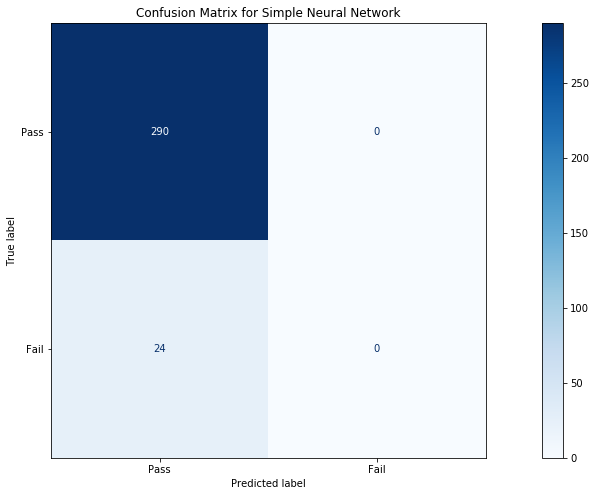

In [105]:
fig, axs = plt.subplots(1, 1, squeeze=True, figsize=(20, 8))
conf_plot = plot_confusion_matrix(mlp_clf, X_lasso_test, y_test, display_labels=labels, cmap=plt.cm.Blues, ax=axs);
conf_plot.ax_.set_title("Confusion Matrix for Simple Neural Network");

#### Use Model Without Feature Selection

In [106]:
from sklearn.neural_network import MLPClassifier

X_as_is_train = sc.fit_transform(X_train)
X_as_is_test = sc.fit_transform(X_test)

mlp_clf_2 = MLPClassifier(max_iter=5000, random_state=1).fit(X_as_is_train, y_train)
mlp_y_hat_train_2 = mlp_clf_2.predict(X_as_is_train)
mlp_y_hat_test_2 = mlp_clf_2.predict(X_as_is_test)
print('Done predicting....')

Done predicting....


In [107]:
mlp_acc_train_2 = accuracy_score(y_train, mlp_y_hat_train_2) # change code here
mlp_acc_test_2 = accuracy_score(y_test, mlp_y_hat_test_2) # change code here

print("Training data accuracy is {:2.0f}%".format(mlp_acc_train_2 * 100))
print("Test data accuracy is {:2.0f}%".format(mlp_acc_test_2 * 100))

Training data accuracy is 100%
Test data accuracy is 90%


In [108]:
labels = ['Pass', 'Fail']

print('Simple Neural Network')
print(classification_report(y_test, mlp_y_hat_test_2, target_names = labels))

Simple Neural Network
              precision    recall  f1-score   support

        Pass       0.92      0.97      0.95       290
        Fail       0.00      0.00      0.00        24

    accuracy                           0.90       314
   macro avg       0.46      0.49      0.47       314
weighted avg       0.85      0.90      0.87       314



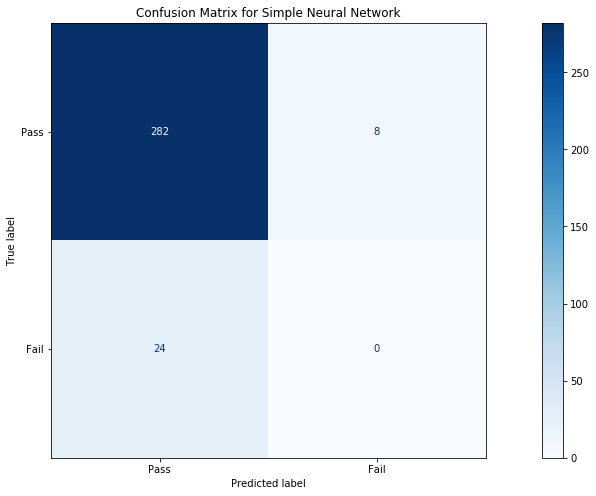

In [109]:
fig, axs = plt.subplots(1, 1, squeeze=True, figsize=(20, 8))
conf_plot = plot_confusion_matrix(mlp_clf_2, X_as_is_test, y_test, display_labels=labels, cmap=plt.cm.Blues, ax=axs);
conf_plot.ax_.set_title("Confusion Matrix for Simple Neural Network");

## Step 2: DNN Model - Use Hidden Layers

#### Using Selected Features Via Lasso

In [136]:
mlp_clf_h = MLPClassifier(max_iter=5000, hidden_layer_sizes=(5), random_state=1).fit(X_lasso_train, y_res_train)
mlp_h_y_hat_train = mlp_clf_h.predict(X_lasso_train)
mlp_h_y_hat_test = mlp_clf_h.predict(X_lasso_test)
print('Done predicting....')

Done predicting....


In [137]:
mlp_h_acc_train = accuracy_score(y_res_train, mlp_h_y_hat_train) # change code here
mlp_h_acc_test = accuracy_score(y_test, mlp_h_y_hat_test) # change code here

print("Training data accuracy is {:2.0f}%".format(mlp_h_acc_train * 100))
print("Test data accuracy is {:2.0f}%".format(mlp_h_acc_test * 100))

Training data accuracy is 96%
Test data accuracy is 92%


In [138]:
labels = ['Pass', 'Fail']

print('Simple Neural Network')
print(classification_report(y_test, mlp_h_y_hat_test, target_names = labels))

Simple Neural Network
              precision    recall  f1-score   support

        Pass       0.93      1.00      0.96       290
        Fail       0.50      0.04      0.08        24

    accuracy                           0.92       314
   macro avg       0.71      0.52      0.52       314
weighted avg       0.89      0.92      0.89       314



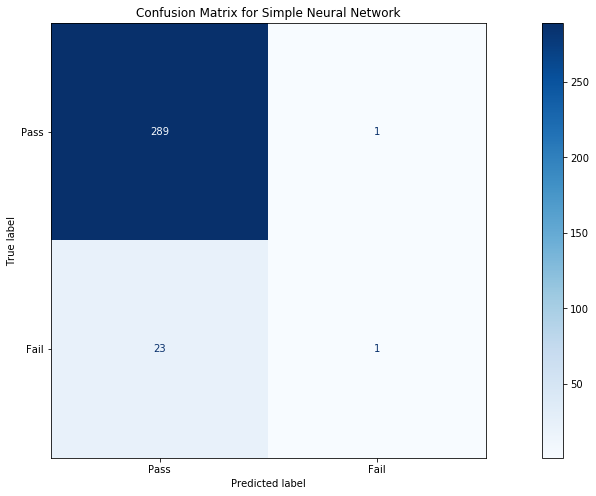

In [139]:
fig, axs = plt.subplots(1, 1, squeeze=True, figsize=(20, 8))
conf_plot = plot_confusion_matrix(mlp_clf_h, X_lasso_test, y_test, display_labels=labels, cmap=plt.cm.Blues, ax=axs);
conf_plot.ax_.set_title("Confusion Matrix for Simple Neural Network");

#### Use Model Without Feature Selection

In [142]:
X_as_is_train = sc.fit_transform(X_train)
X_as_is_test = sc.fit_transform(X_test)

mlp_clf_h_2 = MLPClassifier(max_iter=5000, hidden_layer_sizes=(5), random_state=1).fit(X_as_is_train, y_train)
mlp_h_y_hat_train_2 = mlp_clf_h_2.predict(X_as_is_train)
mlp_h_y_hat_test_2 = mlp_clf_h_2.predict(X_as_is_test)
print('Done predicting....')

Done predicting....


In [143]:
mlp_h_acc_train_2 = accuracy_score(y_train, mlp_h_y_hat_train_2) # change code here
mlp_h_acc_test_2 = accuracy_score(y_test, mlp_h_y_hat_test_2) # change code here

print("Training data accuracy is {:2.0f}%".format(mlp_h_acc_train_2 * 100))
print("Test data accuracy is {:2.0f}%".format(mlp_h_acc_test_2 * 100))

Training data accuracy is 100%
Test data accuracy is 92%


In [144]:
labels = ['Pass', 'Fail']

print('Simple Neural Network')
print(classification_report(y_test, mlp_h_y_hat_test_2, target_names = labels))

Simple Neural Network
              precision    recall  f1-score   support

        Pass       0.93      0.98      0.96       290
        Fail       0.40      0.17      0.24        24

    accuracy                           0.92       314
   macro avg       0.67      0.57      0.60       314
weighted avg       0.89      0.92      0.90       314



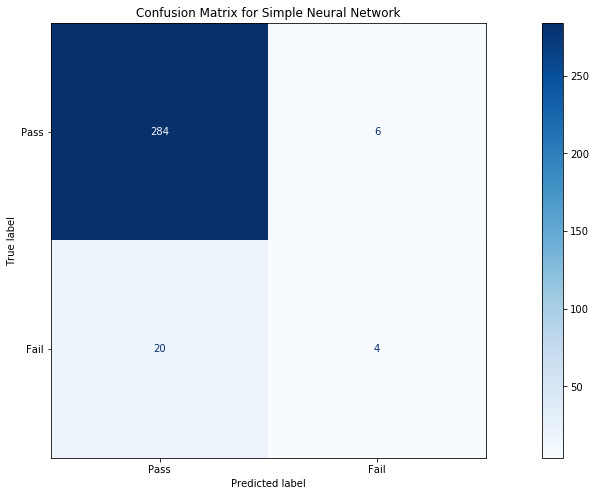

In [145]:
fig, axs = plt.subplots(1, 1, squeeze=True, figsize=(20, 8))
conf_plot = plot_confusion_matrix(mlp_clf_h_2, X_as_is_test, y_test, display_labels=labels, cmap=plt.cm.Blues, ax=axs);
conf_plot.ax_.set_title("Confusion Matrix for Simple Neural Network");

## Step 3: RNN Model

### DIDN"T FIGURE THIS OUT IN TIME

In [155]:

X_lasso_train_reshape = np.reshape(X_lasso_train, (X_lasso_train.shape[0], X_lasso_train.shape[1], 1))

model = keras.models.Sequential()
model.add(keras.layers.LSTM(32,return_sequences=True))
model.add(keras.layers.Dense(1, activation = 'softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_lasso_train_reshape, y_res_train, epochs = 20, batch_size = 32)

Epoch 1/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 2/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 3/20
74/74 [==============================] - 1s 9ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 4/20
74/74 [==============================] - 1s 9ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 5/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 6/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 7/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 8/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 9/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
Epoch 10/20
74/74 [==============================] - 1s 10ms/step - loss: 15.2492 - accuracy: 0.5000
E

## Step 4: Summarize Findings

In an effort to help SECOM manufacturing identify the most critical factors to predicting diapers that meet their quality standandards I've put together several models to assist. Initial findings did seem processing. Both the SVC and Random Forest models have accuracy scores around **92%**. However, they are only accurate for the Passes and not the Failures, which is problematic for our case. SECOM really wants to understand its defects which our most accurate models won't help them do. The team helping SECOM will need more time to investigate the issues with the findings. 